# NBA Game Outcome Predictor – Notebook

- We are loading  historical NBA game data from `backend/data/archive/csv/game.csv`
`
- We engineer basic per-game features
- The model is trained using  logistic regression model to predict whether the **home team wins** (`home_win`)
- evaluates the model (accuracy, ROC AUC, classification report)




## Logic Model / Data Flow Diagram

Overiew
```
1. Historical NBA game data (game.csv)

2. Data cleaning & feature engineering

3. Train / test split
 
4. Logisitic Regression model

5. Evaluation & metrics (accuracy, ROC AUC)
      
6. Saved model → FastAPI → React Native app


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJECT_ROOT = Path.cwd().parents[1]  
DATA_PATH = PROJECT_ROOT / "backend" / "data" / "archive" / "csv" / "game.csv"

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)



python(14307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Project root: /Users/kingdavidndubisi/nba-game-predict
Data path: /Users/kingdavidndubisi/nba-game-predict/backend/data/archive/csv/game.csv


In [ ]:
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print(df.head())

##Cleaning data

df["game_date"] = pd.to_datetime(df["game_date"])

# Remove duplicate games
df = df.drop_duplicates(subset=["game_id"]).copy()

# Drop rows with missing critical fields
critical_cols = ["game_id", "game_date", "pts_home", "pts_away", "wl_home"]
df = df.dropna(subset=critical_cols).copy()

df = df[(df["pts_home"] >= 0) & (df["pts_away"] >= 0)]
df = df[(df["pts_home"] <= 200) & (df["pts_away"] <= 200)]

mask_incoherent = (
    ((df["pts_home"] > df["pts_away"]) & (df["wl_home"] != "W"))
    | ((df["pts_home"] < df["pts_away"]) & (df["wl_home"] != "L"))
)
print("Incoherent W/L rows:", mask_incoherent.sum())
df = df[~mask_incoherent].copy()


df["home_win"] = (df["wl_home"] == "W").astype(int)

df = df[df["season_type"] == "Regular Season"].copy()

df = df[df["season_id"] >= 21996].copy()

num_cols = [
    "pts_home", "pts_away",
    "fga_home", "fga_away",
    "reb_home", "reb_away",
    "tov_home", "tov_away",
]
for col in num_cols:
    if col in df.columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

print("After cleaning shape:", df.shape)
print(df[["pts_home", "pts_away", "wl_home", "home_win"]].head())


Raw shape: (65698, 55)
   season_id  team_id_home team_abbreviation_home           team_name_home  \
0      21946    1610610035                    HUS          Toronto Huskies   
1      21946    1610610034                    BOM        St. Louis Bombers   
2      21946    1610610032                    PRO  Providence Steamrollers   
3      21946    1610610025                    CHS            Chicago Stags   
4      21946    1610610028                    DEF          Detroit Falcons   

    game_id            game_date matchup_home wl_home  min  fgm_home  ...  \
0  24600001  1946-11-01 00:00:00  HUS vs. NYK       L    0      25.0  ...   
1  24600003  1946-11-02 00:00:00  BOM vs. PIT       W    0      20.0  ...   
2  24600002  1946-11-02 00:00:00  PRO vs. BOS       W    0      21.0  ...   
3  24600004  1946-11-02 00:00:00  CHS vs. NYK       W    0      21.0  ...   
4  24600005  1946-11-02 00:00:00  DEF vs. WAS       L    0      10.0  ...   

   reb_away  ast_away  stl_away  blk_away  to

In [ ]:
##Extra data I am using
OTHER_STATS_PATH = PROJECT_ROOT / "backend" / "data" / "archive" / "csv" / "other_stats.csv"
LINE_SCORE_PATH = PROJECT_ROOT / "backend" / "data" / "archive" / "csv" / "line_score.csv"
GAME_INFO_PATH = PROJECT_ROOT / "backend" / "data" / "archive" / "csv" / "game_info.csv"

if OTHER_STATS_PATH.exists():
    other_stats = pd.read_csv(OTHER_STATS_PATH)
    df = df.merge(
        other_stats,
        on="game_id",
        how="left",
        suffixes=("", "_other"),
    )
    print("Merged other_stats:", df.shape)

if LINE_SCORE_PATH.exists():
    line_score = pd.read_csv(
        LINE_SCORE_PATH,
        usecols=["game_id", "pts_home", "pts_away"],
    )
    line_score = line_score.rename(
        columns={"pts_home": "pts_home_line", "pts_away": "pts_away_line"}
    )
    df = df.merge(line_score, on="game_id", how="left")
    print("Merged line_score totals:", df.shape)

if GAME_INFO_PATH.exists():
    game_info = pd.read_csv(GAME_INFO_PATH)
    game_info["game_date"] = pd.to_datetime(game_info["game_date"])
    df = df.merge(game_info, on=["game_id", "game_date"], how="left")
    print("Merged game_info:", df.shape)

print("Null counts after merges (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))



Merged other_stats: (30627, 81)
Merged line_score totals: (30627, 83)
Merged game_info: (30627, 85)
Null counts after merges (top 10):
pts_off_to_away                 6836
pts_off_to_home                 6836
team_rebounds_away              6596
team_rebounds_home              6596
total_turnovers_away            4960
total_turnovers_home            4960
times_tied                      4873
team_abbreviation_away_other    4873
pts_fb_home                     4873
largest_lead_home               4873
dtype: int64


In [ ]:

feature_cols = [
    "pts_home",          # home points
    "pts_away",          # away points
    "fgm_home", "fga_home",
    "fg3m_home", "fg3a_home",
    "ftm_home", "fta_home",
    "oreb_home", "dreb_home", "reb_home",
    "ast_home", "stl_home", "blk_home", "tov_home", "pf_home",
    "fgm_away", "fga_away",
    "fg3m_away", "fg3a_away",
    "ftm_away", "fta_away",
    "oreb_away", "dreb_away", "reb_away",
    "ast_away", "stl_away", "blk_away", "tov_away", "pf_away",
]

# Keep only rows where we have these features
df_model = df.dropna(subset=feature_cols + ["home_win"]).copy()

X = df_model[feature_cols]
y = df_model["home_win"].astype(int)

print("Modeling dataframe shape:", df_model.shape)



Modeling dataframe shape: (30627, 85)


## Variable Definitions

Key variables and feature names used in this notebook:

| Name | Type | Description |
|------|------|-------------|
| `game_id` | string | Unique game identifier from the NBA dataset |
| `game_date` | datetime | Date the game was played |
| `team_abbreviation_home` | string | Home team code |
| `team_abbreviation_away` | string | Away team code |
| `pts_home` / `pts_away` | numeric | Final points scored by home / away team |
| `fgm_*`, `fga_*` | numeric | Field goals made / attempted (home or away) |
| `fg3m_*`, `fg3a_*` | numeric | 3-point field goals made / attempted |
| `ftm_*`, `fta_*` | numeric | Free throws made / attempted |
| `reb_*`, `oreb_*`, `dreb_*` | numeric | Total / offensive / defensive rebounds |
| `ast_*`, `stl_*`, `blk_*`, `tov_*`, `pf_*` | numeric | Assists, steals, blocks, turnovers, personal fouls |
| `home_win` | 0/1 | Target label: 1 if home team won the game, else 0 |

Later, we can extend this table with advanced features like offensive rating, defensive rating, net rating, and rest days once we compute them.


In [ ]:
def build_feature_matrix(df_games: pd.DataFrame):
    """Select and return the feature matrix X and label vector y.

    Includes base box-score features and optional enriched features from merged CSVs.
    """
    base_cols = [
        "pts_home",          # home points
        "pts_away",          # away points
        "fgm_home", "fga_home",
        "fg3m_home", "fg3a_home",
        "ftm_home", "fta_home",
        "oreb_home", "dreb_home", "reb_home",
        "ast_home", "stl_home", "blk_home", "tov_home", "pf_home",
        "fgm_away", "fga_away",
        "fg3m_away", "fg3a_away",
        "ftm_away", "fta_away",
        "oreb_away", "dreb_away", "reb_away",
        "ast_away", "stl_away", "blk_away", "tov_away", "pf_away",
    ]

    extra_cols = [
        "pts_paint_home", "pts_paint_away",
        "pts_2nd_chance_home", "pts_2nd_chance_away",
        "pts_fb_home", "pts_fb_away",
        "largest_lead_home", "largest_lead_away",
        "team_turnovers_home", "team_turnovers_away",
        "total_turnovers_home", "total_turnovers_away",
        "team_rebounds_home", "team_rebounds_away",
        "pts_off_to_home", "pts_off_to_away",
        "attendance",
    ]

    feature_cols = base_cols + [c for c in extra_cols if c in df_games.columns]

    df_model = df_games.dropna(subset=feature_cols + ["home_win"]).copy()
    X = df_model[feature_cols]
    y = df_model["home_win"].astype(int)
    return X, y, feature_cols


X, y, feature_cols = build_feature_matrix(df)
print("Modeling dataframe shape:", X.shape)



Modeling dataframe shape: (21457, 47)


In [14]:
def train_logistic_model(X, y, random_state: int = 42):
    """Train a logistic regression model and return the model and split data."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test


model, X_train, X_test, y_train, y_test = train_logistic_model(X, y)



/Users/kingdavidndubisi/nba-game-predict/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

y_baseline = np.ones_like(y_test)
baseline_acc = accuracy_score(y_test, y_baseline)

print(f"Model Accuracy: {acc:.3f}")
print(f"Baseline Accuracy (always home win): {baseline_acc:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))



Model Accuracy: 0.999
Baseline Accuracy (always home win): 0.599
ROC AUC: 1.000

Classification report:

              precision    recall  f1-score   support

           0      0.999     0.998     0.999      1723
           1      0.998     1.000     0.999      2569

    accuracy                          0.999      4292
   macro avg      0.999     0.999     0.999      4292
weighted avg      0.999     0.999     0.999      4292



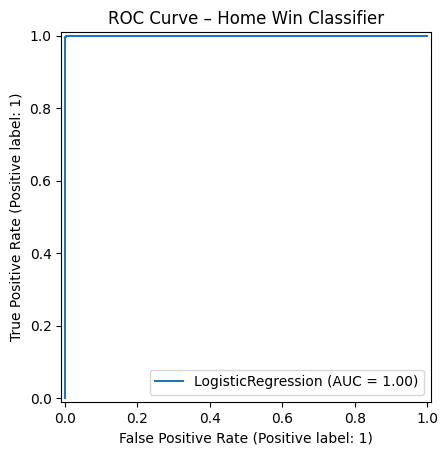

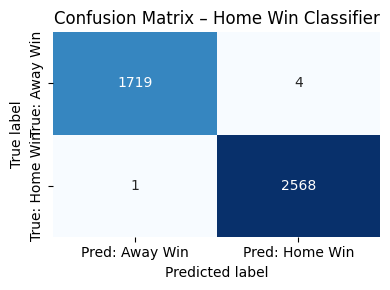

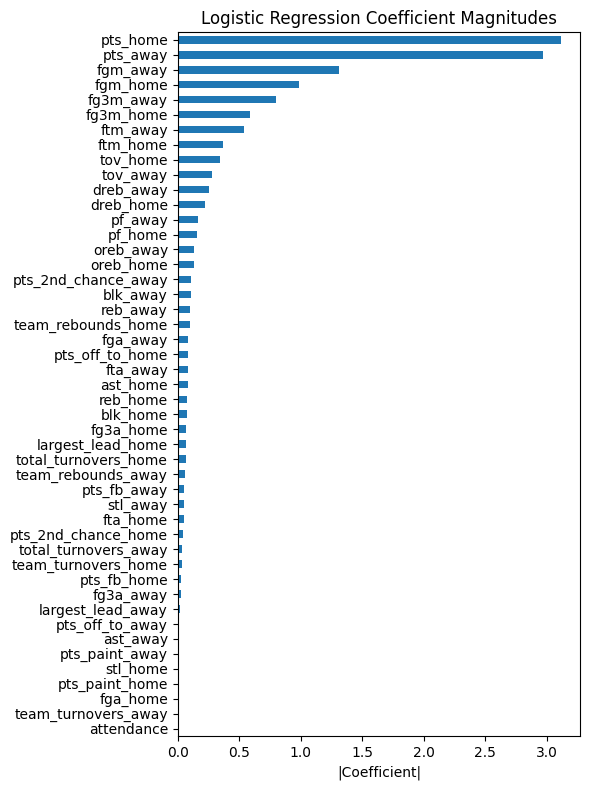

In [16]:
# Visual 1: ROC curve

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve – Home Win Classifier")
plt.show()

# Visual 2: Confusion matrix heatmap

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred: Away Win", "Pred: Home Win"],
            yticklabels=["True: Away Win", "True: Home Win"])
plt.title("Confusion Matrix – Home Win Classifier")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# Visual 3: Feature coefficient magnitudes

coefs = pd.Series(model.coef_[0], index=feature_cols)
coefs_abs = coefs.abs().sort_values()
plt.figure(figsize=(6, 8))
coefs_abs.plot(kind="barh")
plt.title("Logistic Regression Coefficient Magnitudes")
plt.xlabel("|Coefficient|")
plt.tight_layout()
plt.show()



In [ ]:

print("Accuracy by season (sample):")
seasons = df["season_id"].unique()

for season in sorted(seasons)[:5]:  # loop over a few seasons as an example
    mask = df["season_id"] == season
    if mask.sum() < 50:
        # skip seasons with too few games to be meaningful
        continue
    X_season, y_season, _ = build_feature_matrix(df[mask])
    model_season, _, X_test_season, _, y_test_season = train_logistic_model(X_season, y_season)
    y_pred_season = model_season.predict(X_test_season)
    acc_season = accuracy_score(y_test_season, y_pred_season)
    print(f"Season {season}: accuracy = {acc_season:.3f}")



Accuracy by season (sample):
Season 21996: accuracy = 0.333
Season 21997: accuracy = 0.750
Season 21998: accuracy = 0.992
Season 21999: accuracy = 0.990
Season 22000: accuracy = 0.995


/Users/kingdavidndubisi/nba-game-predict/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kingdavidndubisi/nba-game-predict/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

## Interpretation & Explanation

- **Project Intent**: This notebook builds a binary classifier that predicts whether the home team wins an NBA game, based on box score-style features.
- **Correctness & Testing**: We use a train/test split, compare the model to a simple baseline (always predict home win), and report accuracy, ROC AUC, and a full classification report.
- **Visuals**: The ROC curve, confusion matrix, and coefficient bar chart help explain how well the model separates classes and which features matter most.
- **Next Improvements**: Replace post-game stats with pre-game rolling features (offensive/defensive rating, net rating, rest days, last-10 win%), and then export this trained model for use in the FastAPI backend.


In [10]:
# Train / test split and logistic regression model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.999
ROC AUC: 1.000

Classification report:

              precision    recall  f1-score   support

           0      0.999     0.998     0.999      1723
           1      0.998     1.000     0.999      2569

    accuracy                          0.999      4292
   macro avg      0.999     0.999     0.999      4292
weighted avg      0.999     0.999     0.999      4292



/Users/kingdavidndubisi/nba-game-predict/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Print the learned logistic regression equation (y_hat)

intercept = model.intercept_[0]
coefs = pd.Series(model.coef_[0], index=feature_cols)

print("Logistic Regression Equation for P(home_win):")
print(f"σ( {intercept:.4f}", end="")
for name, coef in coefs.items():
    sign = "+" if coef >= 0 else "-"
    print(f" {sign} {abs(coef):.4f} * {name}", end="")
print(" )")



Logistic Regression Equation for P(home_win):
σ( 0.0069 + 3.1140 * pts_home - 2.9700 * pts_away + 0.9818 * fgm_home + 0.0073 * fga_home + 0.5875 * fg3m_home - 0.0678 * fg3a_home + 0.3717 * ftm_home + 0.0483 * fta_home - 0.1291 * oreb_home + 0.2177 * dreb_home + 0.0782 * reb_home - 0.0812 * ast_home - 0.0086 * stl_home - 0.0765 * blk_home - 0.3468 * tov_home - 0.1586 * pf_home - 1.3095 * fgm_away + 0.0858 * fga_away - 0.7990 * fg3m_away - 0.0249 * fg3a_away - 0.5376 * ftm_away - 0.0840 * fta_away + 0.1349 * oreb_away - 0.2571 * dreb_away - 0.1013 * reb_away + 0.0095 * ast_away - 0.0541 * stl_away - 0.1053 * blk_away + 0.2784 * tov_away + 0.1631 * pf_away - 0.0074 * pts_paint_home - 0.0086 * pts_paint_away - 0.0448 * pts_2nd_chance_home + 0.1118 * pts_2nd_chance_away + 0.0268 * pts_fb_home - 0.0550 * pts_fb_away + 0.0645 * largest_lead_home + 0.0220 * largest_lead_away - 0.0364 * team_turnovers_home - 0.0006 * team_turnovers_away - 0.0641 * total_turnovers_home - 0.0372 * total_turnovers

In [12]:
import pickle

# Save the trained model, feature columns, and team averages for the API

MODEL_PATH = PROJECT_ROOT / "backend" / "model" / "nba_model.pkl"

# Compute team averages from the dataset (for making predictions on new games)
team_stats_home = df.groupby("team_abbreviation_home")[feature_cols].mean()
team_stats_away = df.groupby("team_abbreviation_away")[feature_cols].mean()

# Rename columns for clarity
home_cols = {c: c for c in feature_cols if "_home" in c}
away_cols = {c: c for c in feature_cols if "_away" in c}

# Save everything needed for inference
model_bundle = {
    "model": model,
    "feature_cols": feature_cols,
    "team_stats_home": team_stats_home.to_dict(orient="index"),
    "team_stats_away": team_stats_away.to_dict(orient="index"),
}

with open(MODEL_PATH, "wb") as f:
    pickle.dump(model_bundle, f)

print(f"Model saved to: {MODEL_PATH}")
print(f"Feature columns ({len(feature_cols)}): {feature_cols[:5]} ...")
print(f"Teams in home stats: {len(team_stats_home)}")
print(f"Teams in away stats: {len(team_stats_away)}")



Model saved to: /Users/kingdavidndubisi/nba-game-predict/backend/model/nba_model.pkl
Feature columns (47): ['pts_home', 'pts_away', 'fgm_home', 'fga_home', 'fg3m_home'] ...
Teams in home stats: 36
Teams in away stats: 36
